In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew, kurtosis

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/Project/Condominium.csv")
df = df.drop(columns=['Property Type'])

In [4]:
df.head()

,Location (Kuala Lumpur),Rooms,Bathrooms,Car Parks,Furnishing,Property Details,Size Type,Size Number (sq. ft.),Price Range
0,setapak,3,2.0,1.0,Partly Furnished,Intermediate,Built-up,805.0,Low
1,taman desa,3,2.0,1.0,Unfurnished,Intermediate,Built-up,850.0,Low
2,taman desa,3,2.0,1.0,Unfurnished,Intermediate,Built-up,850.0,Low
3,setapak,3,2.0,1.0,Unfurnished,Intermediate,Built-up,802.0,Low
4,setapak,3,2.0,1.0,Unfurnished,Intermediate,Built-up,850.0,Low


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17698 entries, 0 to 17697
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Location (Kuala Lumpur)  17698 non-null  object 
 1   Rooms                    17698 non-null  int64  
 2   Bathrooms                17698 non-null  float64
 3   Car Parks                17698 non-null  float64
 4   Furnishing               17698 non-null  object 
 5   Property Details         17698 non-null  object 
 6   Size Type                17698 non-null  object 
 7   Size Number (sq. ft.)    17698 non-null  float64
 8   Price Range              17698 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 1.2+ MB


In [6]:
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])

Number of rows:  17698
Number of columns:  9


In [7]:
df.isnull().sum()

,0
Location (Kuala Lumpur),0
Rooms,0
Bathrooms,0
Car Parks,0
Furnishing,0
Property Details,0
Size Type,0
Size Number (sq. ft.),0
Price Range,0


In [8]:
print("Total Missing Value: ", df.isnull().sum().sum())

Total Missing Value:  0


In [9]:
df = df[df['Furnishing'] != 'Unknown']

##Basic Statistical Analysis

In [10]:
df.describe().astype('int')

,Rooms,Bathrooms,Car Parks,Size Number (sq. ft.)
count,17501,17501,17501,17501
mean,3,2,1,1414
std,0,0,0,481
min,2,1,1,417
25%,3,2,1,1076
50%,3,2,2,1300
75%,4,3,2,1610
max,5,4,3,6156


In [11]:
df['Location (Kuala Lumpur)'].value_counts()

,count
Location (Kuala Lumpur),
mont kiara,2720
cheras,1440
setapak,1435
jalan klang lama (old klang road),1400
bukit jalil,1351
klcc,801
sentul,775
dutamas,755
desa parkcity,525


In [12]:
df['Rooms'].value_counts()

,count
Rooms,
3,8225
4,6496
2,1723
5,1057


In [13]:
df['Bathrooms'].value_counts()

,count
Bathrooms,
2.0,10393
3.0,4028
4.0,2728
1.0,352


In [14]:
df['Car Parks'].value_counts()

,count
Car Parks,
2.0,11028
1.0,5483
3.0,990


In [15]:
df['Furnishing'].value_counts()

,count
Furnishing,
Partly Furnished,8749
Fully Furnished,4883
Unfurnished,3869


In [16]:
df['Property Details'].value_counts()

,count
Property Details,
Intermediate,13083
Corner,3991
EndLot,299
Penthouse,73
Duplex,51
Studio,2
SOHO,1
Triplex,1


In [17]:
df['Size Type'].value_counts()

,count
Size Type,
Built-up,16575
Land area,926


In [18]:
df['Size Number (sq. ft.)'].value_counts().sort_index()

,count
Size Number (sq. ft.),
417.0,1
450.0,1
463.0,1
485.0,1
500.0,2
...,...
4482.0,1
4520.0,1
4569.0,1


Price Range
High              0.261871
Low               0.252728
Medium            0.249357
Extremely High    0.236044
Name: proportion, dtype: float64


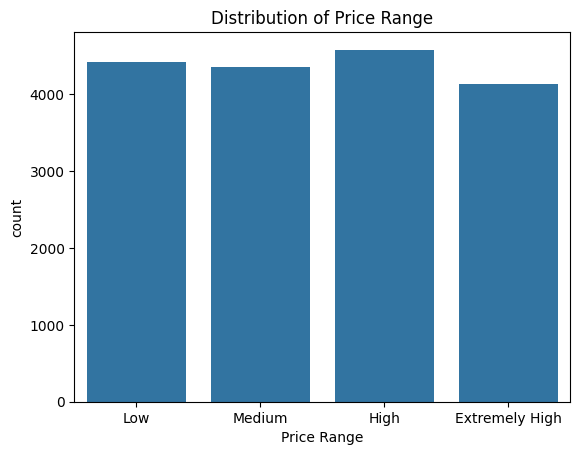

In [19]:
print(df['Price Range'].value_counts(normalize=True))
sns.countplot(data=df, x='Price Range')
plt.title('Distribution of Price Range')
plt.show()


## EDA

In [25]:
property_numerical_columns = df[['Rooms', 'Bathrooms', 'Car Parks', 'Size Number (sq. ft.)']]

# Calculate Median, Mode, IQR, Skewness, Kurtosis and Varience
statistics = {
    'Feature': [],
    'Median': [],
    'Mode': [],
    'IQR': [],
    'Variance': [],
    'Skewness': [],
    'Kurtosis': []
}

for column in property_numerical_columns:
    statistics['Feature'].append(column)
    statistics['Median'].append(df[column].median())
    statistics['Mode'].append(df[column].mode().values[0] if not df[column].mode().empty else None)
    statistics['IQR'].append(df[column].quantile(0.75) - df[column].quantile(0.25))
    statistics['Variance'].append(df[column].var())
    statistics['Skewness'].append(skew(df[column]))
    statistics['Kurtosis'].append(kurtosis(df[column]))

statistics = pd.DataFrame(statistics)

statistics

,Feature,Median,Mode,IQR,Variance,Skewness,Kurtosis
0,Rooms,3.0,3.0,1.0,0.556390,0.091919,-0.302366
1,Bathrooms,2.0,2.0,1.0,0.601539,0.800404,-0.489893
2,Car Parks,2.0,2.0,1.0,0.303973,-0.034049,-0.408124
3,Size Number (sq. ft.),1300.0,1100.0,534.0,231568.038602,1.582699,4.348846


**Median:**
- The middle value for each feature (e.g., 3 for Rooms, 1300 for Size).

**Mode:**
- The most frequent value (e.g., 3 for Rooms, 1100 for Size).

**IQR (Interquartile Range):**
- Spread of the middle 50% of values (e.g., 1 for Rooms, 534 for Size).

**Variance:**
- Measures the data spread from the mean. Higher variance means more spread (e.g., 231,568 for Size).

**Skewness:**
- Indicates symmetry of data.
- Positive values: Right-skewed (e.g., Size = 1.58).
- Near zero: Symmetric (e.g., Rooms = 0.09).

**Kurtosis:**
- Positive: Sharp peak (e.g., Size = 4.35).
- Near zero: Flatter peak (e.g., Rooms = -0.30).

## Check Covariance & Corelation

In [26]:
property_numerical_columns.cov().astype(int)

,Rooms,Bathrooms,Car Parks,Size Number (sq. ft.)
Rooms,0,0,0,228
Bathrooms,0,0,0,264
Car Parks,0,0,0,107
Size Number (sq. ft.),228,264,107,231568


**Diagonal Values** (e.g., 228, 264, 107, 231,568):

- Represent the variance of each feature (Rooms, Bathrooms, Car Parks, Size).

**Off-Diagonal Values (e.g., 0s):**
- Indicate no covariance between features; they are not correlated in this dataset.

In [27]:
property_numerical_columns.corr()

,Rooms,Bathrooms,Car Parks,Size Number (sq. ft.)
Rooms,1.000000,0.645028,0.397823,0.636140
Bathrooms,0.645028,1.000000,0.401224,0.709186
Car Parks,0.397823,0.401224,1.000000,0.406354
Size Number (sq. ft.),0.636140,0.709186,0.406354,1.000000


- The statistics above show that all the variables have positive relationships with each other.
- 1.000: Perfect positive correlation (e.g., a feature with itself).
- 0.645: Moderate positive correlation (e.g., Rooms and Bathrooms).
- 0.397: Weak positive correlation (e.g., Rooms and Car Parks).

## Data Overview and Distributions

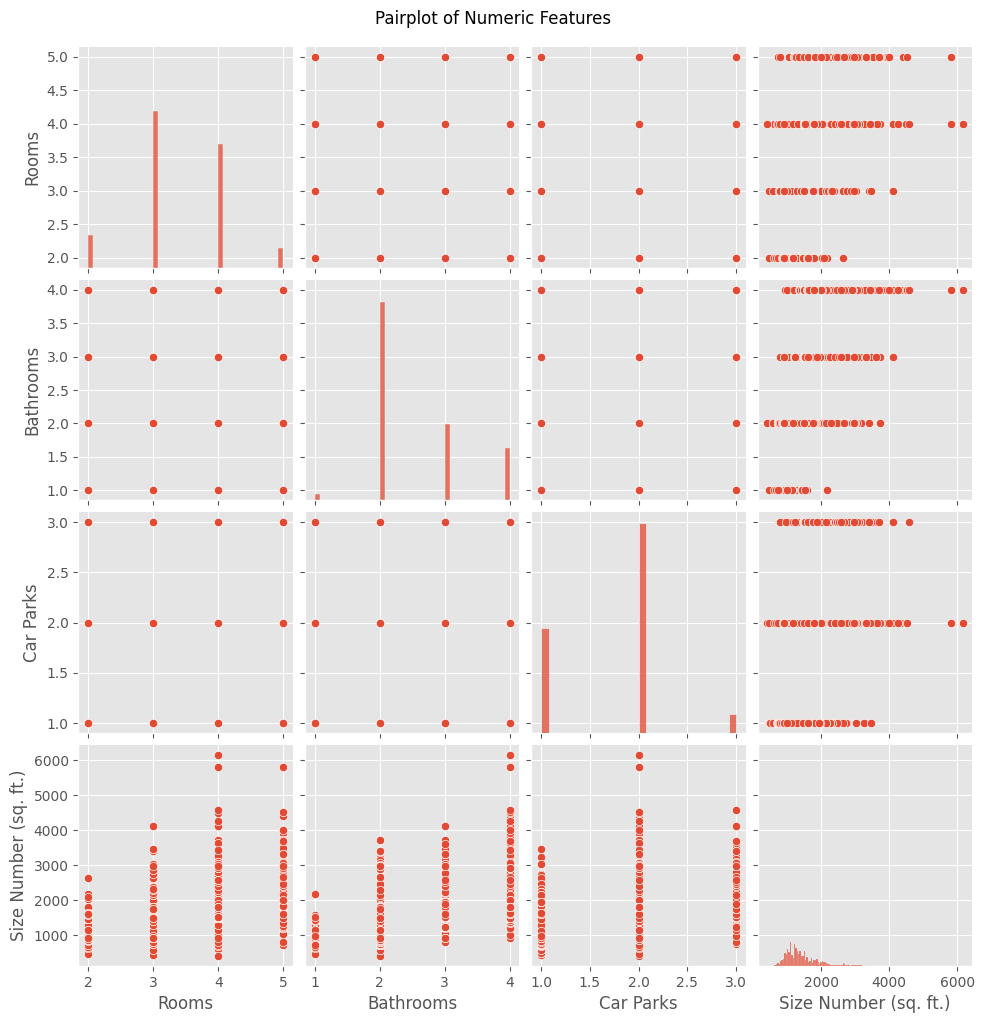

In [31]:
# List of columns to visualize
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Create visualizations
visualizations = []

sns.pairplot(df[numeric_cols])
plt.suptitle("Pairplot of Numeric Features", y=1.02)
visualizations.append("Pairplot of Numeric Features")
plt.show()

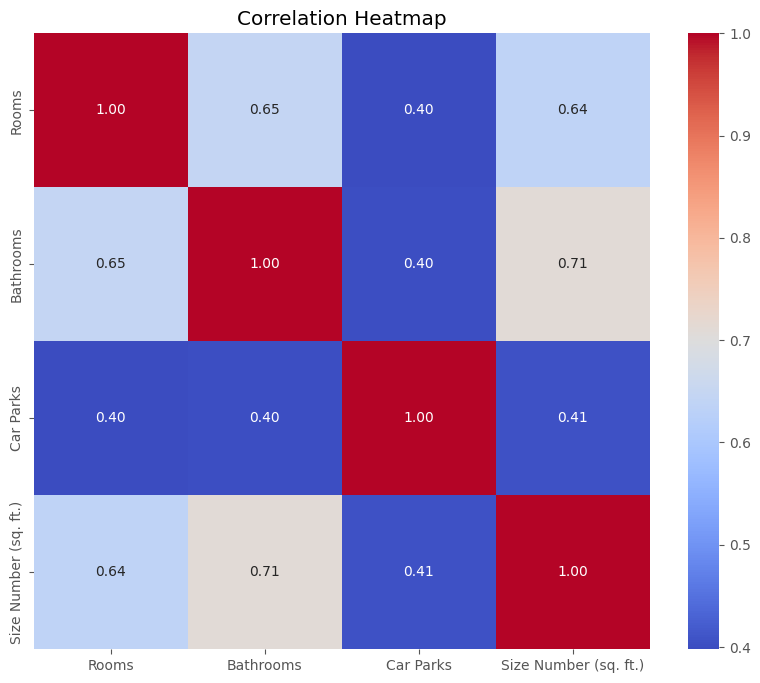

In [32]:
# Heatmap for correlations
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title("Correlation Heatmap")
visualizations.append("Correlation Heatmap")
plt.show()

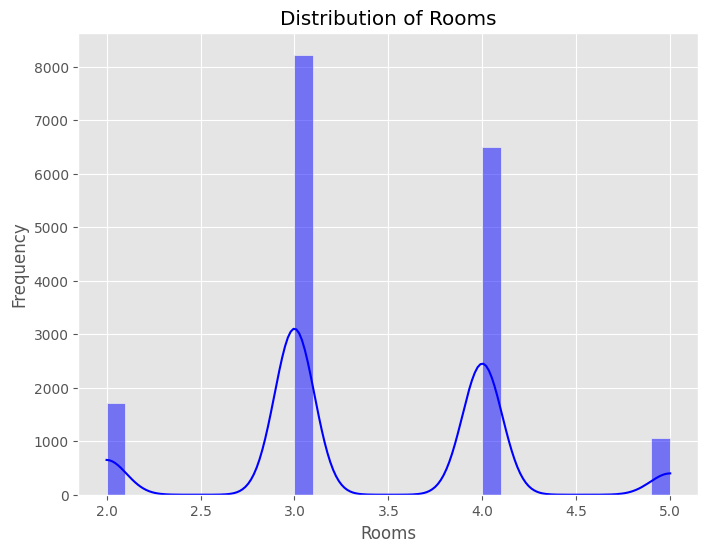

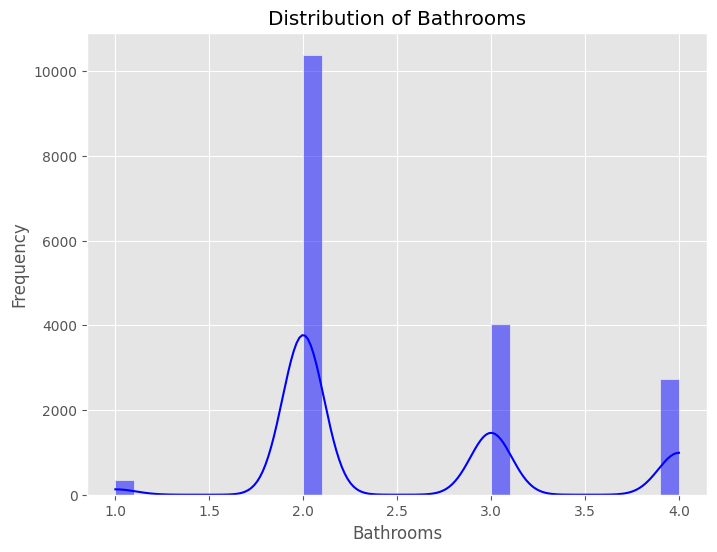

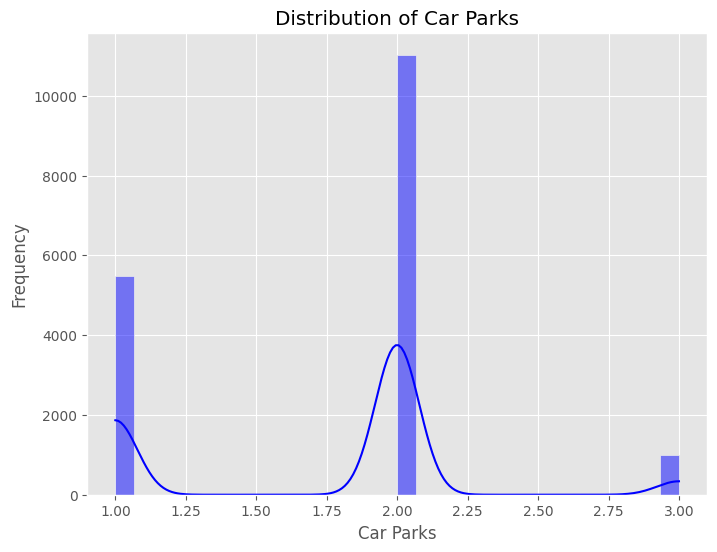

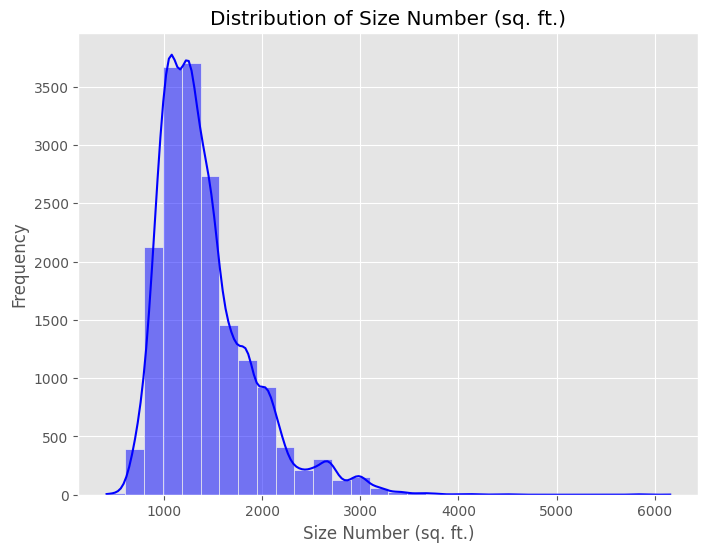

In [33]:
# Distribution plots for numeric columns
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    visualizations.append(f"Distribution of {col}")
    plt.show()

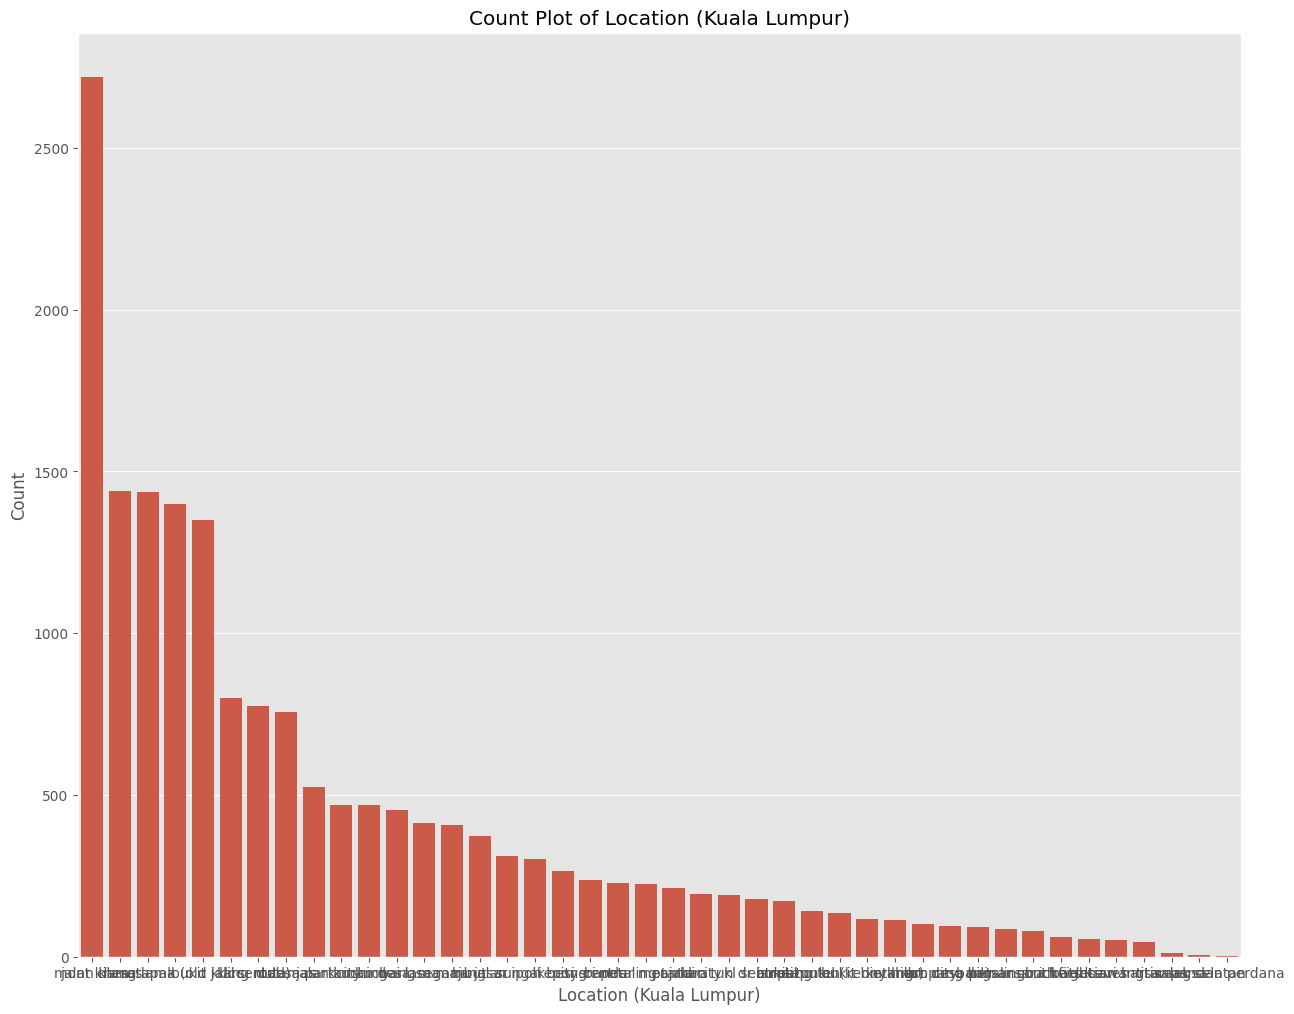

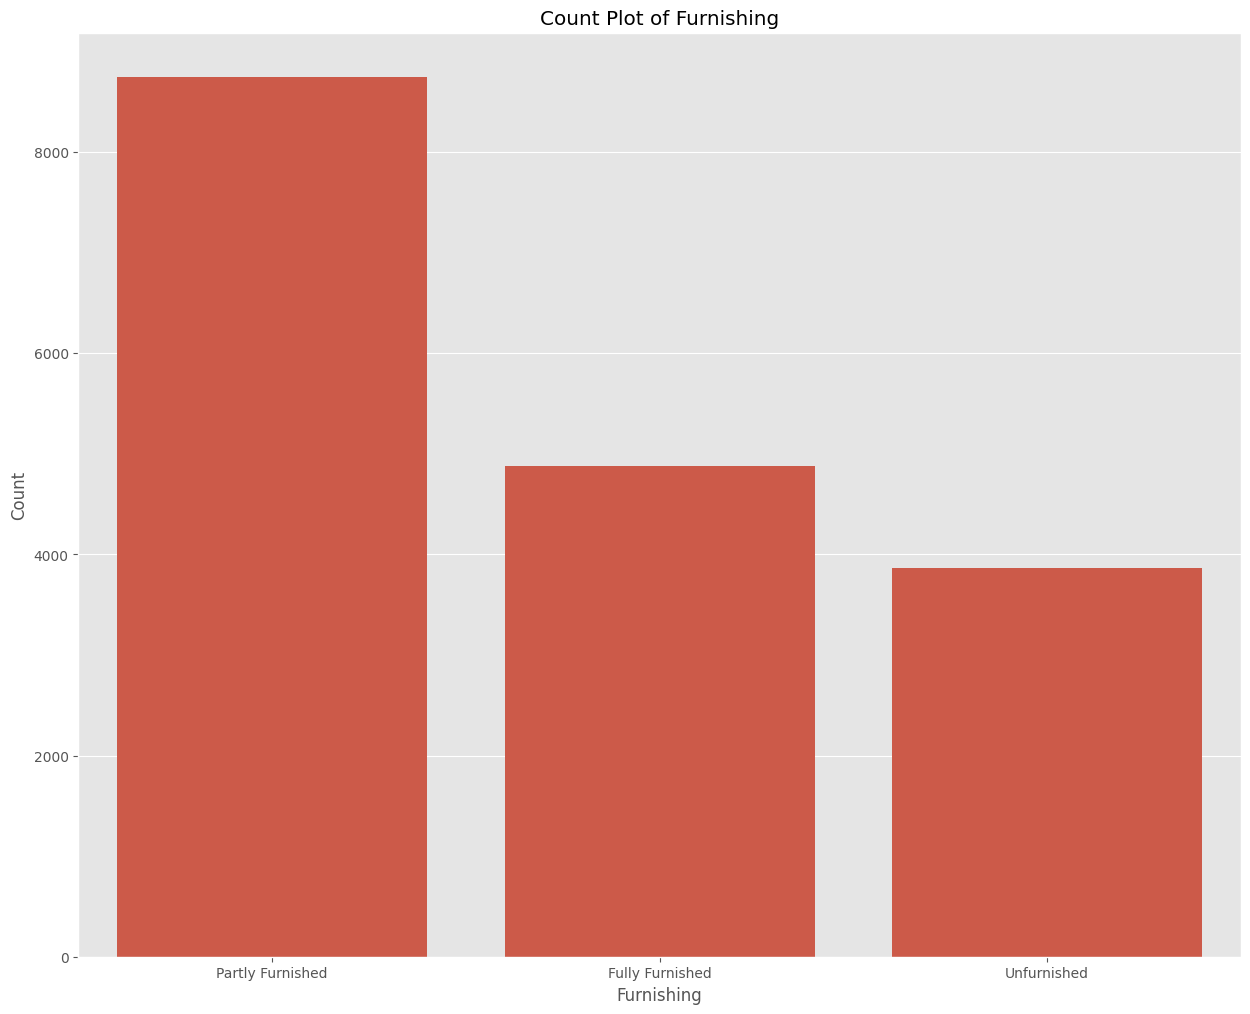

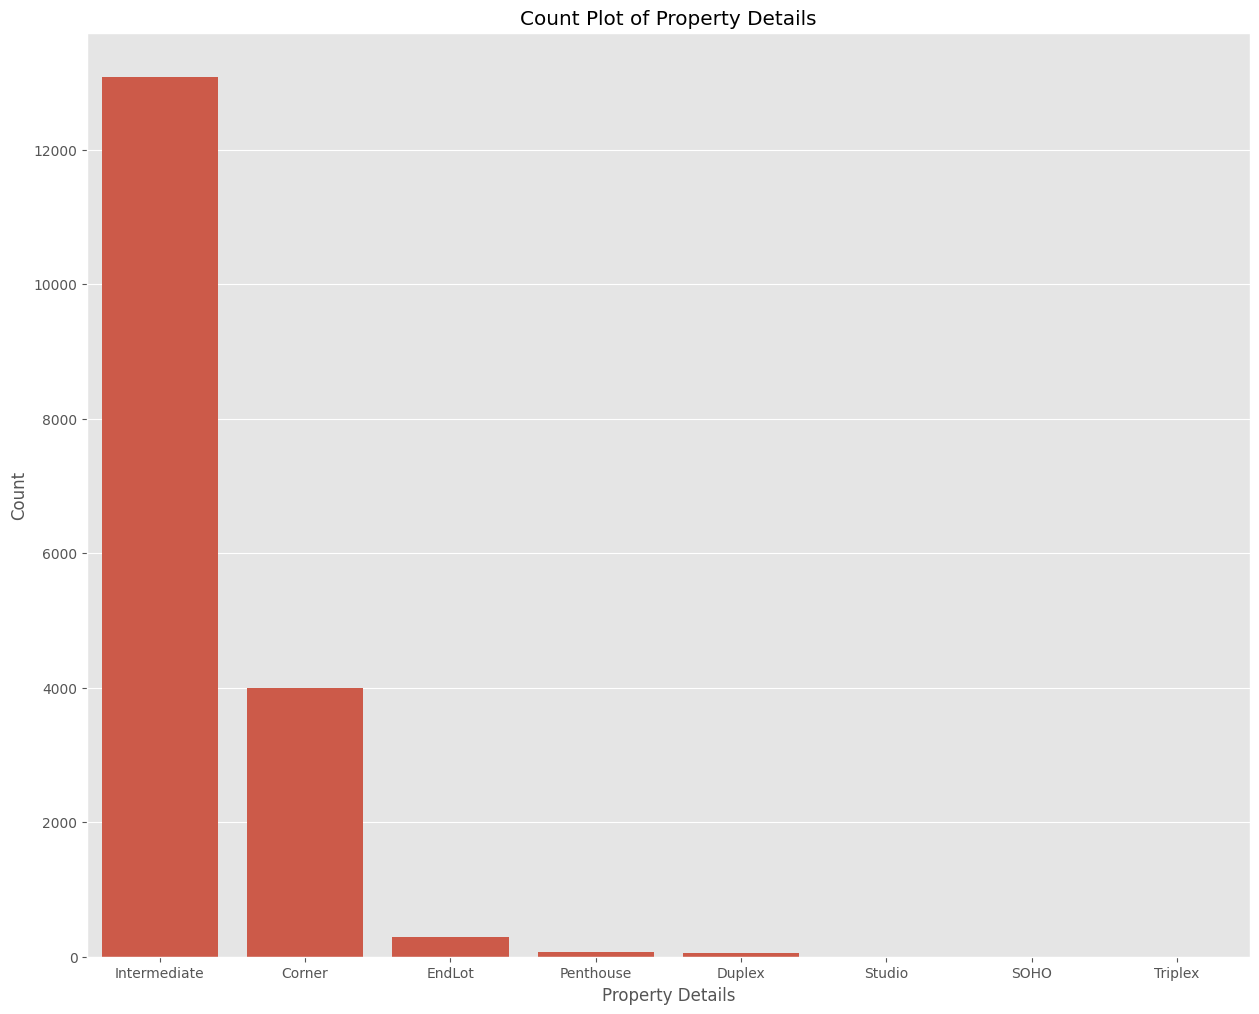

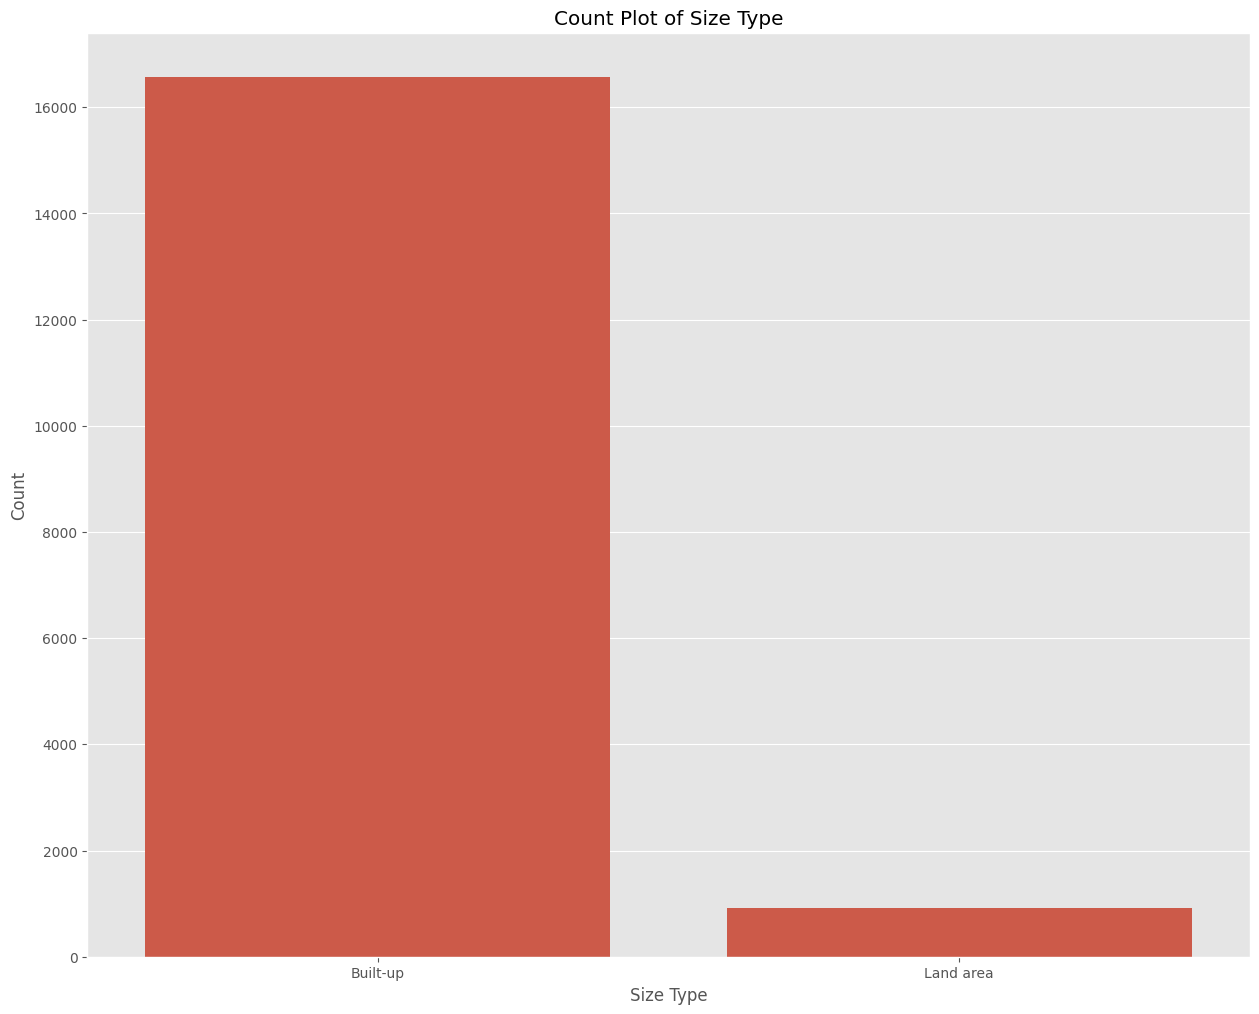

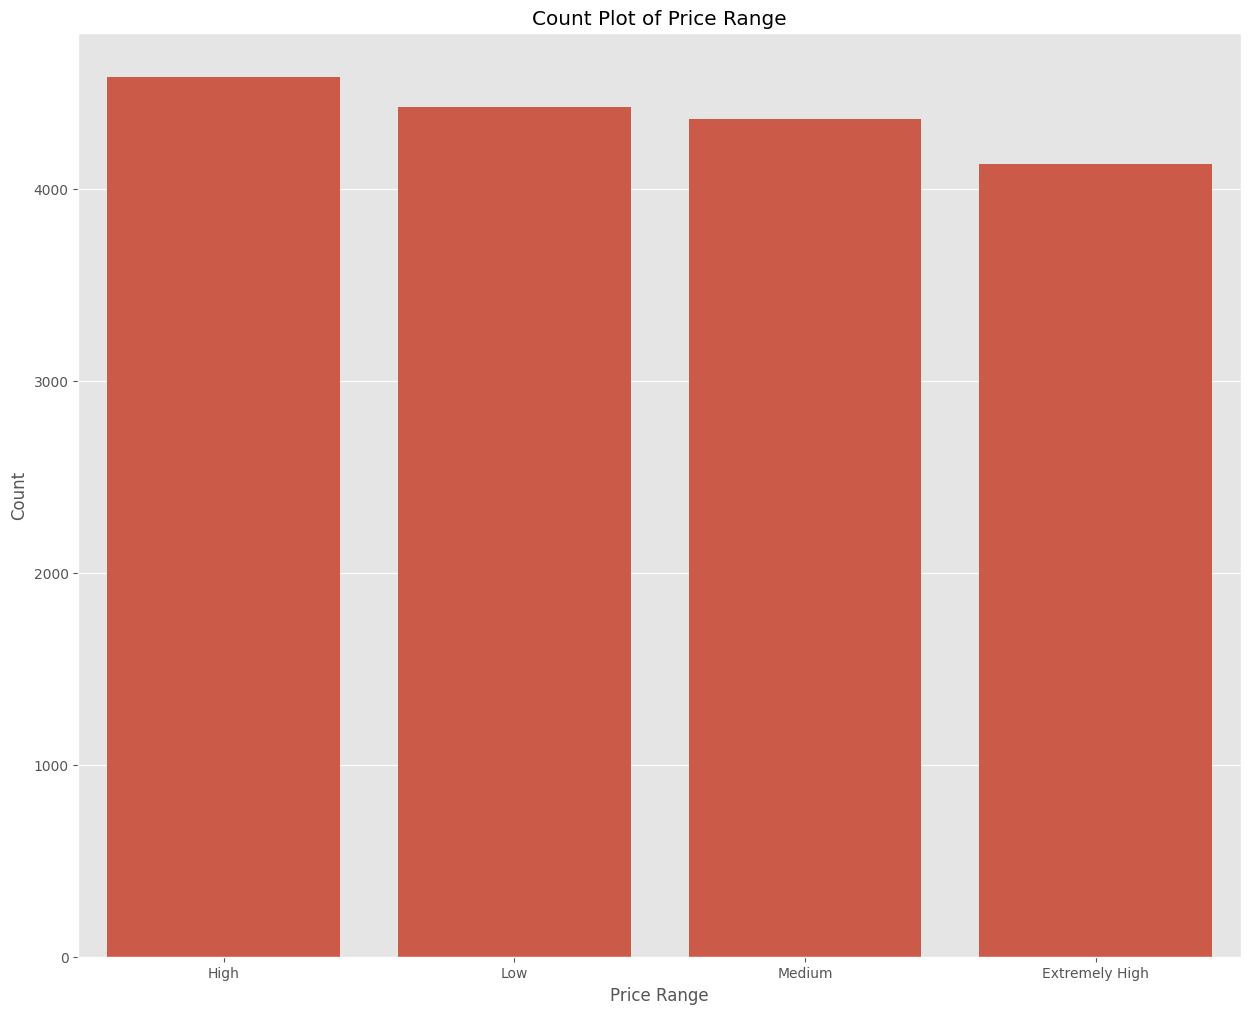

In [37]:
# Count plots for categorical features
for cat_col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=cat_col, order=df[cat_col].value_counts().index)
    plt.title(f"Count Plot of {cat_col}")
    plt.xlabel(cat_col)
    plt.ylabel("Count")
    visualizations.append(f"Count Plot of {cat_col}")
    plt.show()


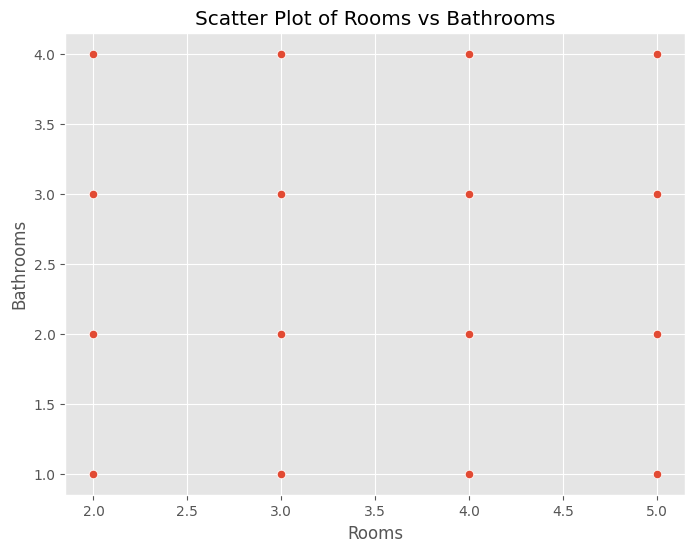

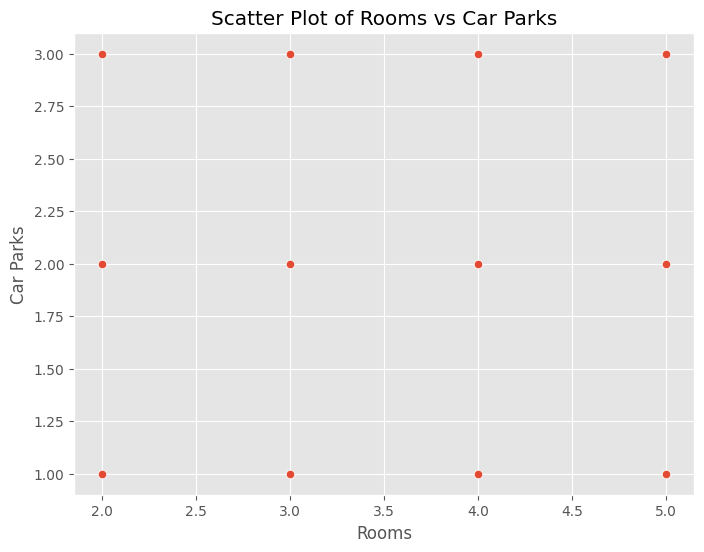

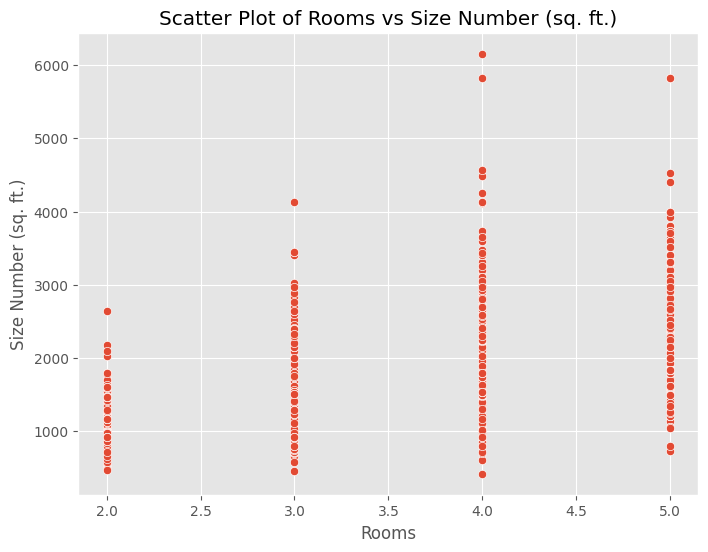

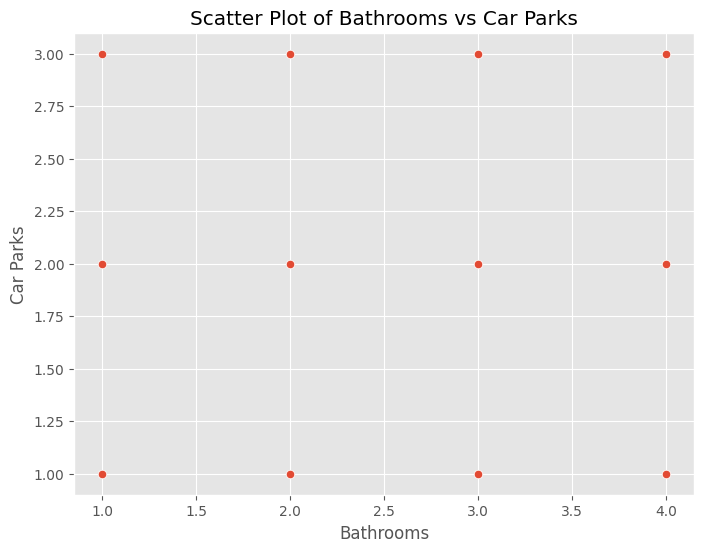

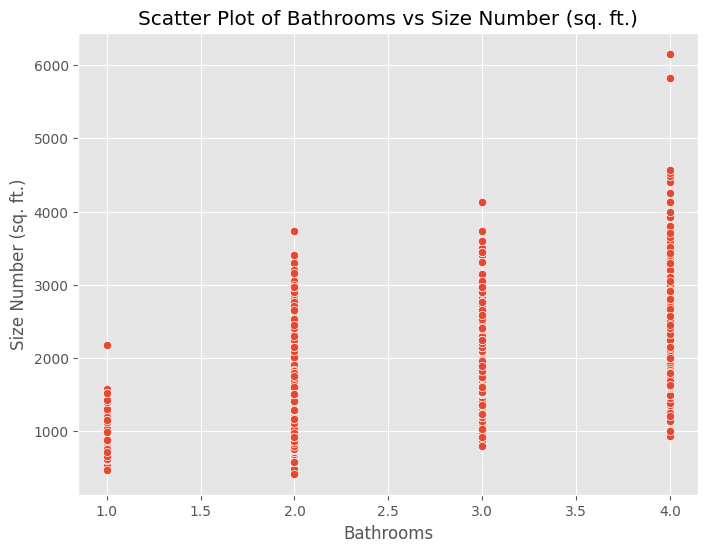

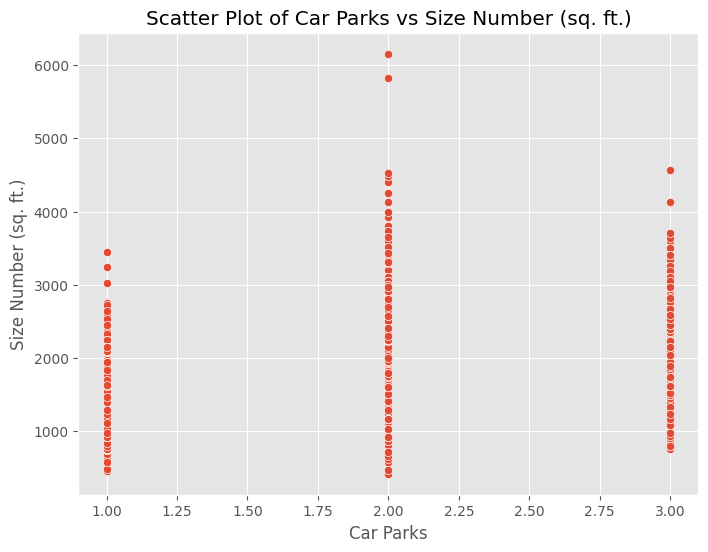

In [38]:
# Scatter plots for numeric combinations
for i in range(len(numeric_cols)):
    for j in range(i + 1, len(numeric_cols)):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x=numeric_cols[i], y=numeric_cols[j])
        plt.title(f"Scatter Plot of {numeric_cols[i]} vs {numeric_cols[j]}")
        plt.xlabel(numeric_cols[i])
        plt.ylabel(numeric_cols[j])
        visualizations.append(f"Scatter Plot of {numeric_cols[i]} vs {numeric_cols[j]}")
        plt.show()

<ipython-input-40-3728cc810333>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=common_configurations, x='Count', y=common_configurations.apply(lambda x: f"{x['Rooms']}R-{x['Bathrooms']}B-{x['Car Parks']}CP", axis=1), palette='flare')


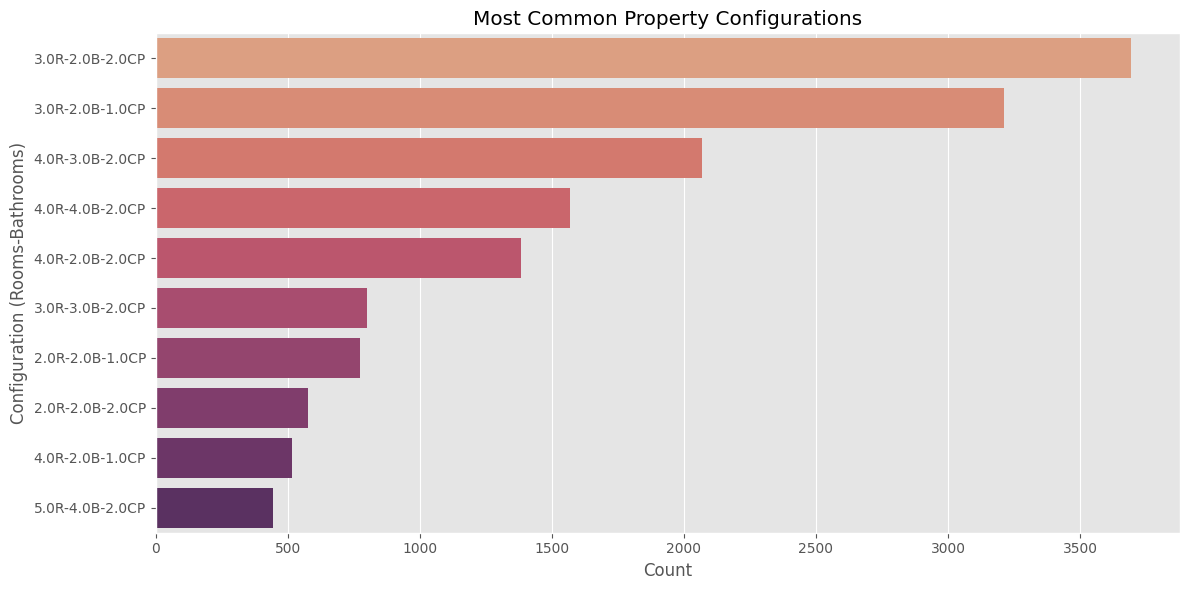

In [40]:
# Group by rooms and bathrooms, then count occurrences
common_configurations = df.groupby(['Rooms', 'Bathrooms','Car Parks']).size().reset_index(name='Count').sort_values(by='Count', ascending=False).head(10)

# Bar plot for most common configurations
plt.figure(figsize=(12, 6))
sns.barplot(data=common_configurations, x='Count', y=common_configurations.apply(lambda x: f"{x['Rooms']}R-{x['Bathrooms']}B-{x['Car Parks']}CP", axis=1), palette='flare')
plt.title('Most Common Property Configurations')
plt.xlabel('Count')
plt.ylabel('Configuration (Rooms-Bathrooms)')
plt.tight_layout()
plt.show()


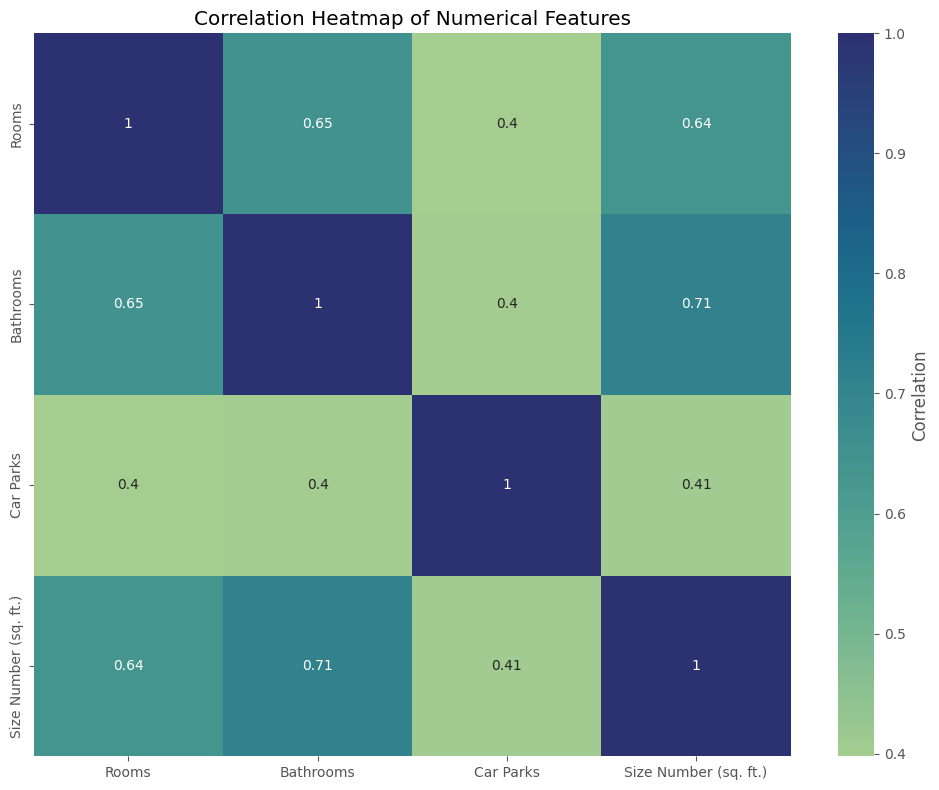

In [42]:
# Correlation matrix
correlation_matrix = df[['Rooms', 'Bathrooms', 'Car Parks', 'Size Number (sq. ft.)']].corr()

# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="crest", cbar_kws={'label': 'Correlation'})
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


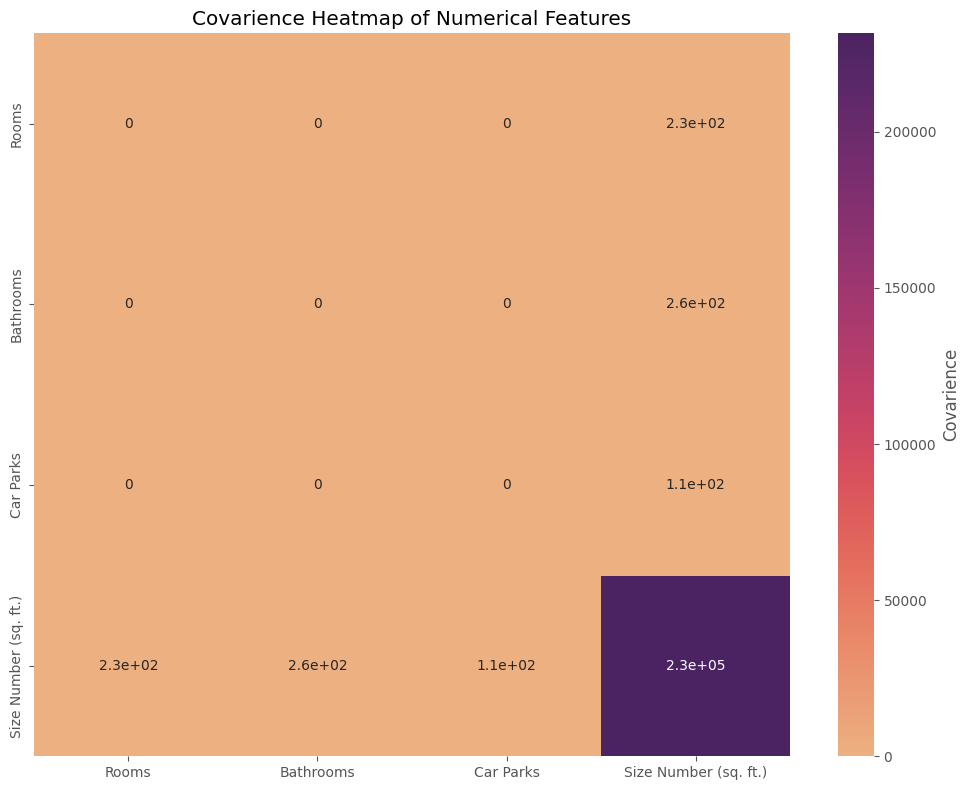

In [45]:
# Covarience matrix
covarience_matrix = df[['Rooms', 'Bathrooms', 'Car Parks', 'Size Number (sq. ft.)']].cov()
covarience_matrix = covarience_matrix.astype(int)

# Heatmap of covarience
plt.figure(figsize=(10, 8))
sns.heatmap(covarience_matrix, annot=True, cmap="flare", cbar_kws={'label': 'Covarience'})
plt.title('Covarience Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

## Dataset Classes Balacing for Model Training

In [20]:
X = df.drop('Price Range', axis=1)  # Features
y = df['Price Range']              # Target

le = LabelEncoder()
X['Location (Kuala Lumpur)'] = le.fit_transform(X['Location (Kuala Lumpur)'])
X['Furnishing'] = le.fit_transform(X['Furnishing'])
X['Property Details'] = le.fit_transform(X['Property Details'])
X['Size Type'] = le.fit_transform(X['Size Type'])

In [21]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Original dataset shape: {X.shape}, {y.value_counts()}")
print(f"Resampled dataset shape: {X_resampled.shape}, {y_resampled.value_counts()}")

Original dataset shape: (17501, 8), Price Range
High              4583
Low               4423
Medium            4364
Extremely High    4131
Name: count, dtype: int64
Resampled dataset shape: (18332, 8), Price Range
Low               4583
Medium            4583
High              4583
Extremely High    4583
Name: count, dtype: int64


In [22]:
# Combine features and target into one DataFrame
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)

# Export to CSV
resampled_df.to_csv('/content/drive/MyDrive/Colab Notebooks/TES Project/Condo2.csv', index=False)

print("Resampled dataset successfully saved as 'Condominium2.csv'")


Resampled dataset successfully saved as 'Condominium2.csv'
